In [1]:
import sys
import os
import json
import pyspark
import datetime
from pyspark.sql import *
import pyspark.sql.functions as F
from pyspark.sql.types import *
import datetime
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns

/home/karna/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/karna/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/karna/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
spark = SparkSession.builder.getOrCreate()

In [54]:
tones_df = spark.read.parquet("tone_mentions_europe.parquet")

In [81]:
tones = tones_df.toPandas()

In [82]:
tones.columns = ["DAY","MONTH","YEAR","tone_mean","STATE"]

In [83]:
tones.head()

,DAY,MONTH,YEAR,tone_mean,STATE
0,10,8,2017,-5.108700,VE
1,27,6,2016,-2.260378,VE
2,25,8,2017,-3.031185,PM
3,7,4,2015,-0.489160,KN
4,7,11,2017,-2.388809,KN


In [58]:
DATA_FOLDER = "mentions_counts/"

In [59]:
countries = pd.read_csv(DATA_FOLDER+"countries.csv")[["ISO", "Country", "Region"]]
countries.ISO = countries.ISO.str.upper()
countries.set_index("ISO", inplace=True)

regions = countries.Region.unique()[:-1]
print("Regions list:", regions)

fips_to_iso = pd.read_csv(DATA_FOLDER+"fips-10-4-to-iso-country-codes.csv")
countries = countries.merge(fips_to_iso, how="left", left_index=True, right_on="ISO")
countries.drop(columns=["Name"], inplace=True)
countries.dropna()

countries.head(10)

Regions list: ['Asia' 'Europe' 'Africa' 'Oceania' 'Americas']


,Country,Region,FIPS,ISO
0,Afghanistan,Asia,AF,AF
278,Åland Islands,Europe,NaN,AX
2,Albania,Europe,AL,AL
3,Algeria,Africa,AG,DZ
4,American Samoa,Oceania,AQ,AS
5,Andorra,Europe,AN,AD
6,Angola,Africa,AO,AO
7,Anguilla,Americas,AV,AI
8,Antarctica,NaN,AY,AQ
9,Antigua and Barbuda,Americas,AC,AG


In [60]:
counts_file = DATA_FOLDER+"mentions_counts_by_state_and_day.csv"

In [61]:
counts = pd.read_csv(counts_file)

In [62]:
def join_country(counts, states=None):
    counts = counts.merge(countries[["Country", "ISO", "FIPS", "Region"]], how="inner", left_on="STATE", right_on="FIPS")
    counts.dropna(inplace=True)
    counts = counts.assign(DATE=pd.to_datetime(counts[["YEAR", "MONTH", "DAY"]]))
    if states is not None:
        counts = counts[counts.STATE.isin(states)]

    counts.drop(columns=["FIPS", "YEAR", "MONTH", "DAY", "ISO", "STATE", "Region"], inplace=True)
    return counts

In [63]:
states = countries[countries.Region=="Europe"].FIPS.values

In [64]:
counts = join_country(counts,states)
counts.head()

,GLOBAL_COUNT,ENV_COUNT,Country,DATE
11064,568,48.0,Albania,2015-10-23
11065,246,60.0,Albania,2016-01-28
11066,337,136.0,Albania,2016-02-18
11067,52,2.0,Albania,2016-12-04
11069,1145,180.0,Albania,2016-05-30


In [84]:
tones = join_country(tones, states)
tones.head()

,tone_mean,Country,DATE
3305,-2.413834,Russian Federation,2017-08-11
3306,-2.134429,Russian Federation,2015-05-09
3307,-2.342646,Russian Federation,2015-11-23
3308,-2.521173,Russian Federation,2016-05-23
3309,-2.227376,Russian Federation,2017-02-06


In [85]:
tones = tones.groupby([(pd.Grouper(key='DATE',freq='W')),"Country"]).mean()
tones = tones.reset_index()
tones.head()

,DATE,Country,tone_mean
0,2015-02-22,Albania,-2.328649
1,2015-02-22,Austria,-1.311470
2,2015-02-22,Belarus,-2.443157
3,2015-02-22,Belgium,-1.985543
4,2015-02-22,Bosnia and Herzegovina,-2.520943


In [67]:
counts = counts.groupby([(pd.Grouper(key='DATE',freq='W')),"Country"]).sum()
counts = counts.reset_index()
counts.head()

,DATE,Country,GLOBAL_COUNT,ENV_COUNT
0,2015-02-22,Albania,459,157.0
1,2015-02-22,Austria,4047,1061.0
2,2015-02-22,Belarus,6261,1318.0
3,2015-02-22,Belgium,7391,890.0
4,2015-02-22,Bosnia and Herzegovina,688,72.0


In [69]:
counts = counts.assign(Ratio=counts.ENV_COUNT/counts.GLOBAL_COUNT)
counts.drop(columns=['GLOBAL_COUNT','ENV_COUNT'],inplace=True)
counts.head()

,DATE,Country,Ratio
0,2015-02-22,Albania,0.342048
1,2015-02-22,Austria,0.262170
2,2015-02-22,Belarus,0.210510
3,2015-02-22,Belgium,0.120417
4,2015-02-22,Bosnia and Herzegovina,0.104651


In [137]:
count_tone = counts.merge(tones, on= ['DATE','Country'])

In [138]:
count_tone.head()

,DATE,Country,Ratio,tone_mean
0,2015-02-22,Albania,0.342048,-2.328649
1,2015-02-22,Austria,0.262170,-1.311470
2,2015-02-22,Belarus,0.210510,-2.443157
3,2015-02-22,Belgium,0.120417,-1.985543
4,2015-02-22,Bosnia and Herzegovina,0.104651,-2.520943


In [146]:
count_tone.describe()

,Ratio,tone_mean
count,6066.000000,6066.000000
mean,0.250710,-1.699812
std,0.156266,1.201065
min,0.009622,-8.147631
25%,0.152457,-2.438322
50%,0.212613,-1.850292
75%,0.303561,-1.108475
max,1.000000,6.607185


In [151]:
count_tone_f = count_tone[count_tone['tone_mean']<2]
count_tone_f = count_tone_f[count_tone_f['tone_mean']>-4]
count_tone_f.head()

,DATE,Country,Ratio,tone_mean
0,2015-02-22,Albania,0.342048,-2.328649
1,2015-02-22,Austria,0.262170,-1.311470
2,2015-02-22,Belarus,0.210510,-2.443157
3,2015-02-22,Belgium,0.120417,-1.985543
4,2015-02-22,Bosnia and Herzegovina,0.104651,-2.520943


In [152]:
count_tone_f.describe()

,Ratio,tone_mean
count,5897.000000,5897.000000
mean,0.248687,-1.704725
std,0.152237,1.020296
min,0.009622,-3.996720
25%,0.152470,-2.415936
50%,0.212003,-1.845189
75%,0.301246,-1.129964
max,1.000000,1.986755


In [159]:
def sep_year(table):
    return table[table['DATE'] < '2016-01-01'],\
    table[(table['DATE'] < '2017-01-01') & (table['DATE'] >= '2016-01-01')],\
    table[(table['DATE'] < '2018-01-01') & (table['DATE'] >= '2017-01-01')]

In [160]:
counts_2015,counts_2016,counts_2017 = sep_year(count_tone_f)

In [74]:
import altair as alt
alt.renderers.enable('notebook')

RendererRegistry.enable('notebook')

In [98]:
def circle_scatter_plot(table,year):
    x_title = "Date in %d (weekly divided)" % (year)
    
    plot = alt.Chart(table).mark_circle(
        opacity=0.8,
        stroke='black',
        strokeWidth=1
    ).encode(
        alt.X('DATE:T', axis=alt.Axis(labelAngle=0, title=x_title)),
        alt.Y('Country:N'),
        alt.Size('Ratio:Q',
            legend=alt.Legend(title='Ratio')
        ),
        alt.Color('tone_mean:Q', scale=alt.Scale(range=['red','white','green']),legend=alt.Legend(title='Tone'))
    ).properties(
        width=500,
        height=800
    ).properties(
    title='Evolution of the ratio of ecological mentions over time by country in Europe')
    
    return plot


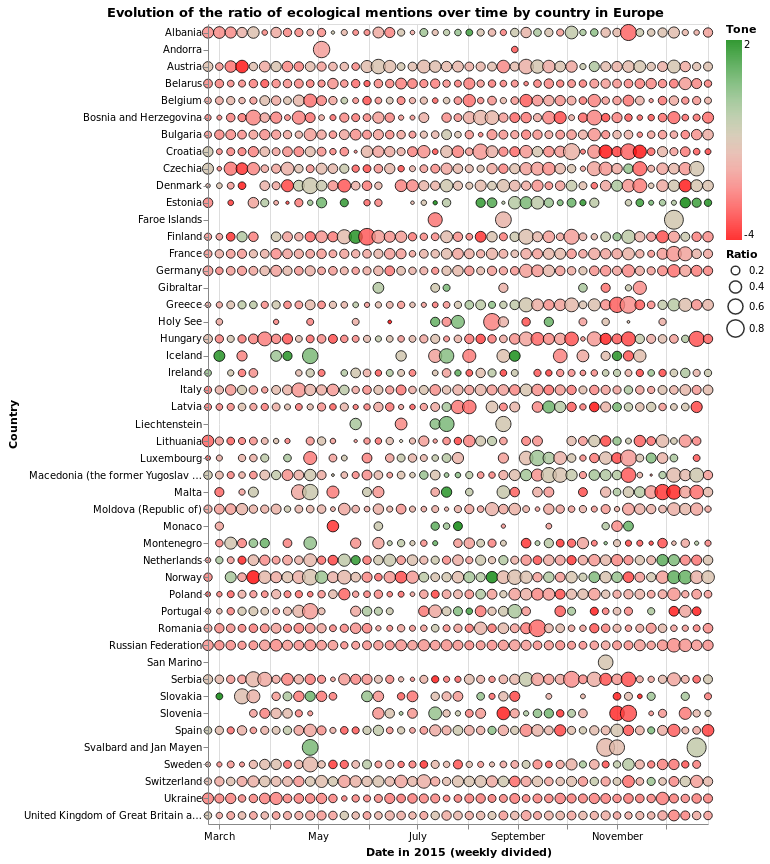

In [154]:
circle_scatter_plot(counts_2015,2015)

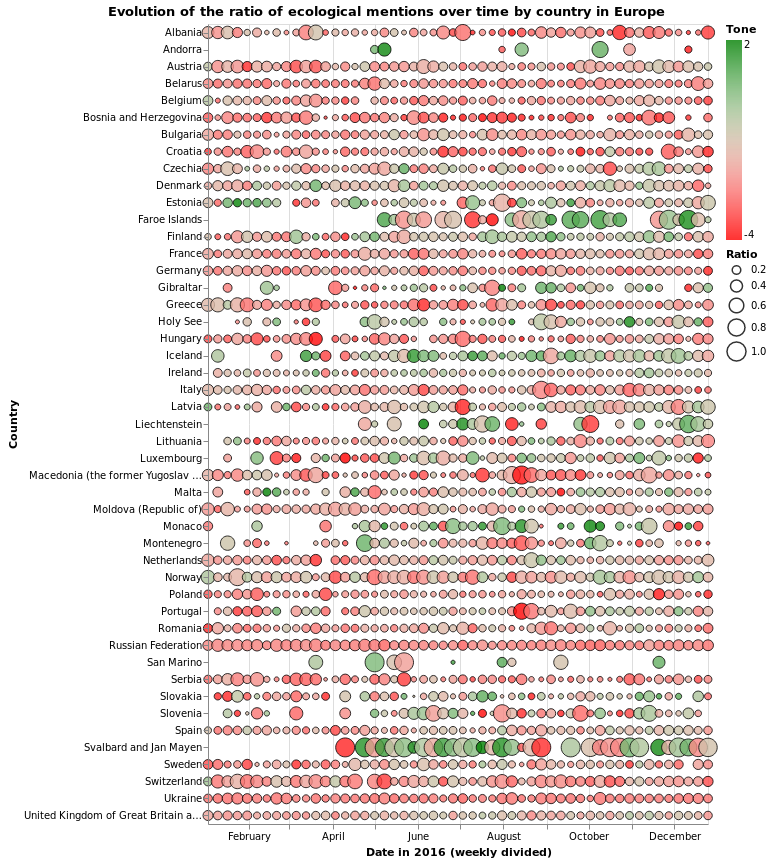

In [161]:
circle_scatter_plot(counts_2016,2016)

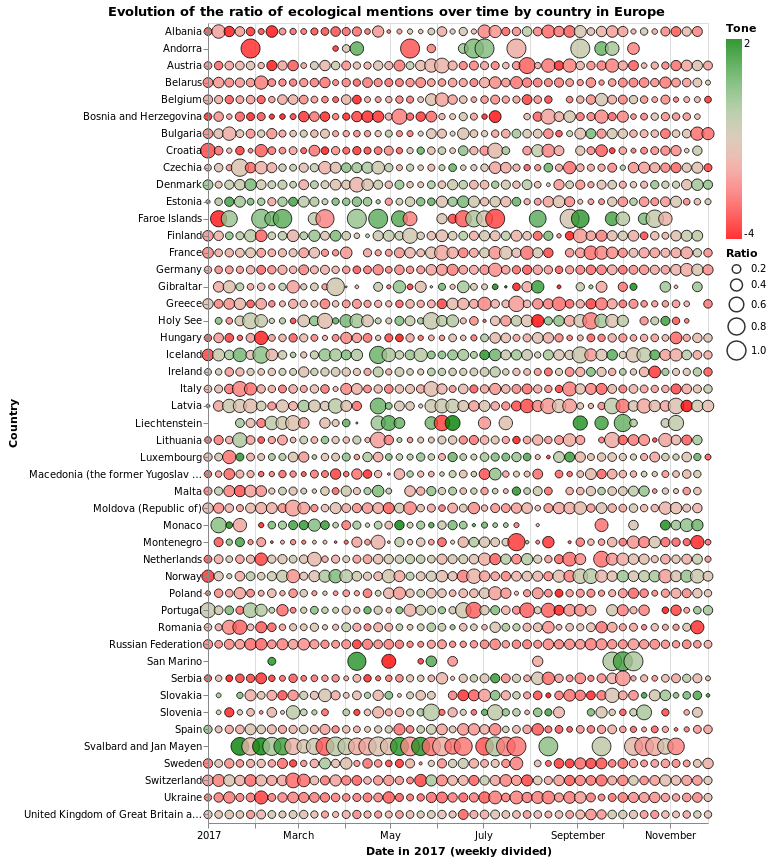

In [162]:
circle_scatter_plot(counts_2017,2017)